# Acker Merrall & Condit

## Scraping Data

In [105]:
#acker merrall and condit! not ackerman! XD
import Scrapers.ackerman_scraper as ack_scraper
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
raw = ack_scraper.dataframe_ackerman_auction()

{1185: '183 Apr 7, 2018 (NY)', 1187: '183A Apr 21, 2018 (HK)', 1188: '184 May 16, 2018 (NY)', 1190: '184A Jun 9, 2018 (HK)', 1192: '185 Jun 20, 2018 (NY)', 1184: '182A Mar 24, 2018 (HK)', 1196: '186 Sep 7, 2018 (NY)', 1197: '185A Sep 22, 2018 (HK)', 1165: '175A Sep 23, 2017 (HK)', 1168: '177 Oct 13, 2017 (NY)', 1202: '187 Oct 12, 2018 (NY)', 1172: '178 Nov 18, 2017 (NY)', 1173: '177A Dec 9, 2017 (HK)', 1174: '179 Dec 13, 2017 (NY)', 1177: '181A Jan 27, 2018 (HK)', 1179: '181 Feb 9, 2018 (NY)', 1163: '176 Sep 9, 2017 (NY)', 1181: '182 Mar 10, 2018 (NY)', 1170: '176A Nov 4, 2017 (HK)'}
1185 183 Apr 7, 2018 (NY)
1187 183A Apr 21, 2018 (HK)
1188 184 May 16, 2018 (NY)
1190 184A Jun 9, 2018 (HK)
1192 185 Jun 20, 2018 (NY)
1184 182A Mar 24, 2018 (HK)
1196 186 Sep 7, 2018 (NY)
1197 185A Sep 22, 2018 (HK)
1165 175A Sep 23, 2017 (HK)
1168 177 Oct 13, 2017 (NY)
1202 187 Oct 12, 2018 (NY)
1172 178 Nov 18, 2017 (NY)
1173 177A Dec 9, 2017 (HK)
1174 179 Dec 13, 2017 (NY)
1177 181A Jan 27, 2018 (HK)
1

In [107]:
print( raw.shape )
raw.head()

(31962, 14)


,Auction.Date,Auction.ID,Auction.Name,BottleQuantity,BottleSummary,Conditions,Designation,LotNo,Producer,ProducerAndDesignation,Size,SoldAmount,Vintage,Wine
0,None,1185,"183 Apr 7, 2018 (NY)",1,1 magnum,1x1 magnum owc lscl,Hommage a Jacques Perrin,1,Chateau de Beaucastel,"Hommage a Jacques Perrin, Chateau de Beaucastel",magnum,1860.0,1989,Chateauneuf du Pape
1,None,1185,"183 Apr 7, 2018 (NY)",3,3 bottles,1lscl,Hommage a Jacques Perrin,2,Chateau de Beaucastel,"Hommage a Jacques Perrin, Chateau de Beaucastel",bottle,1736.0,2001,Chateauneuf du Pape
2,None,1185,"183 Apr 7, 2018 (NY)",1,1 magnum,1x1 magnum owc,Hommage a Jacques Perrin,2,Chateau de Beaucastel,"Hommage a Jacques Perrin, Chateau de Beaucastel",magnum,1736.0,2001,Chateauneuf du Pape
3,None,1185,"183 Apr 7, 2018 (NY)",1,1 bottle,3.75cm bc cuc gsvl lscl outstanding color and ...,None,3,Chateau Rayas,Chateau Rayas,bottle,13640.0,1929,Chateauneuf du Pape
4,None,1185,"183 Apr 7, 2018 (NY)",1,1 bottle,7.5cm bc excellent color lscl lstl,None,4,Chateau Rayas,Chateau Rayas,bottle,4712.0,1959,Chateauneuf du Pape


## Basic Data Cleaning

In [155]:
# identify which columsn to look into how to clean for null values
toFix = []
for column, typecol in raw.dtypes.iteritems():
    #if( typecol == "object"):
    #    blanks = raw[ raw[column] == "" ]
    #else:
    blanks = raw[ raw[column].isnull() ]
    if(blanks.size):
        toFix.append(column)
        toFix.append(blanks.shape)
toFix

['Auction.Date',
 (31962, 14),
 'Designation',
 (18274, 14),
 'Producer',
 (2515, 14)]

Auction Date may not be important yet, but for time, may be need to be parsed from the Auction Name?
We'll default blank designation and producers to the wine
If just one is blank, the ProducerAndDesignation column will still have things and that will be the primary anyway

In [194]:
# confirming that's true
only_producer = raw[ raw["Producer"].isnull() & raw["Designation"].notnull() ]
producer_check = only_producer["Designation"] == only_producer["ProducerAndDesignation"]
print(producer_check.all())

only_designation = raw[ raw["Designation"].isnull() & raw["Producer"].notnull() ]
designation_check = only_designation["Producer"] == only_designation["ProducerAndDesignation"]
print(designation_check.all())

True
True


In [188]:
# filling in when both are empty
raw.loc[ raw["ProducerAndDesignation"].isnull() ] = raw[raw["ProducerAndDesignation"].isnull()]["Wine"]


ValueError: Must have equal len keys and value when setting with an iterable

In [193]:
raw[raw["ProducerAndDesignation"].isnull()]

,Auction.Date,Auction.ID,Auction.Name,BottleQuantity,BottleSummary,Conditions,Designation,LotNo,Producer,ProducerAndDesignation,Size,SoldAmount,Vintage,Wine


## Aggregation of Data for Individual Bottles

In [5]:
# need to group by lot number, append most rows, but the price seems to be static so don't sum that
# for now,  filtering away mixed lots by saying anything that has shared lot numbers shoudl be removed

df = raw.drop_duplicates(subset=['Auction.ID', 'LotNo'], keep=False)
df = df.reset_index()
print( df.shape )
df.head()

(13394, 15)

In [7]:
# convert to dollars
HKDUSD = 0.1277
def toUSD(row):
    if 'HK' in row['Auction.Name']:
       return row['SoldAmount'] * HKDUSD
    else:
       return row['SoldAmount'] 

df['SoldAmountUSD'] = df.apply( toUSD, axis = 1 )
    
# compute unit price by bottle
df['UnitPriceUSD'] = df[ 'SoldAmountUSD' ] / df[ 'BottleQuantity' ]

# bottle sizes only for now
bottle_df = df[(df["BottleSummary"].str.contains("bottle") == True) & (df["BottleSummary"].str.contains("half") == False)]
bottle_df.shape

(10924, 17)

In [54]:
#some like Burgundys or champagnes need ProducerAndDesignation WITH Wine
#for Bordeauxs they are often all the same
bottle_grouped = bottle_df.groupby(['Vintage', "Wine", "ProducerAndDesignation"]).UnitPriceUSD.agg( ['min', 'mean', 'max', "count"] )
bottle_grouped = bottle_grouped.reset_index()
bottle_grouped = bottle_grouped.sort_values('count', ascending = False)

### Looking at an example: Mouton Rothschild 1982

In [55]:
mouton_grouped = bottle_grouped[ bottle_grouped["ProducerAndDesignation"].str.contains("Mouton") ]
mouton_all = bottle_df[ bottle_df["ProducerAndDesignation"].str.contains( "Mouton") ]
mouton_grouped.head()

In [161]:
mouton_1982 = mouton_all[ mouton_all['Vintage'] == "1982"]
mouton_1982.head()

,index,Auction.Date,Auction.ID,Auction.Name,BottleQuantity,BottleSummary,Conditions,Designation,LotNo,Producer,ProducerAndDesignation,Size,SoldAmount,Vintage,Wine,SoldAmountUSD,UnitPriceUSD
319,457,None,1185,"183 Apr 7, 2018 (NY)",12,12 bottles,1vhs 1wc 1x12 bottle chateau mouton rothschild...,None,369,Chateau Mouton Rothschild,Chateau Mouton Rothschild,bottle,16120.0,1982,Chateau Mouton Rothschild,16120.000,1343.333333
320,458,None,1185,"183 Apr 7, 2018 (NY)",10,10 bottles,1x12 bottle owc 2bn 2cuc 2spc 4nc 8lbsl,None,370,Chateau Mouton Rothschild,Chateau Mouton Rothschild,bottle,12400.0,1982,Chateau Mouton Rothschild,12400.000,1240.000000
579,793,None,1185,"183 Apr 7, 2018 (NY)",10,10 bottles,1x12 bottle owc 4ts 6bn,None,646,Chateau Mouton Rothschild,Chateau Mouton Rothschild,bottle,12400.0,1982,Chateau Mouton Rothschild,12400.000,1240.000000
1232,707,None,1187,"183A Apr 21, 2018 (HK)",12,12 bottles,12vlscl 1lstl 1vhs 2nc 2ts 8bn 8lwrl,None,593,Chateau Mouton Rothschild,Chateau Mouton Rothschild,bottle,119040.0,1982,Chateau Mouton Rothschild,15201.408,1266.784000
1278,760,None,1187,"183A Apr 21, 2018 (HK)",2,2 bottles,1bn 1lbsl 1lgsl 1ts,None,644,Chateau Mouton Rothschild,Chateau Mouton Rothschild,bottle,19840.0,1982,Chateau Mouton Rothschild,2533.568,1266.784000


In [68]:
mouton_1982.head()
# if looking at mouton 1945, the cheap one "believed to be" that vintage, which may explain low price

,index,Auction.Date,Auction.ID,Auction.Name,BottleQuantity,BottleSummary,Conditions,Designation,LotNo,Producer,ProducerAndDesignation,Size,SoldAmount,Vintage,Wine,SoldAmountUSD,UnitPriceUSD
319,457,None,1185,"183 Apr 7, 2018 (NY)",12,12 bottles,1vhs 1wc 1x12 bottle chateau mouton rothschild...,None,369,Chateau Mouton Rothschild,Chateau Mouton Rothschild,bottle,16120.0,1982,Chateau Mouton Rothschild,16120.0000,1343.333333
320,458,None,1185,"183 Apr 7, 2018 (NY)",10,10 bottles,1x12 bottle owc 2bn 2cuc 2spc 4nc 8lbsl,None,370,Chateau Mouton Rothschild,Chateau Mouton Rothschild,bottle,12400.0,1982,Chateau Mouton Rothschild,12400.0000,1240.000000
579,793,None,1185,"183 Apr 7, 2018 (NY)",10,10 bottles,1x12 bottle owc 4ts 6bn,None,646,Chateau Mouton Rothschild,Chateau Mouton Rothschild,bottle,12400.0,1982,Chateau Mouton Rothschild,12400.0000,1240.000000
1232,707,None,1187,"183A Apr 21, 2018 (HK)",12,12 bottles,12vlscl 1lstl 1vhs 2nc 2ts 8bn 8lwrl,None,593,Chateau Mouton Rothschild,Chateau Mouton Rothschild,bottle,119040.0,1982,Chateau Mouton Rothschild,15201.4080,1266.784000
1278,760,None,1187,"183A Apr 21, 2018 (HK)",2,2 bottles,1bn 1lbsl 1lgsl 1ts,None,644,Chateau Mouton Rothschild,Chateau Mouton Rothschild,bottle,19840.0,1982,Chateau Mouton Rothschild,2533.5680,1266.784000
1452,1080,None,1187,"183A Apr 21, 2018 (HK)",3,3 bottles,1bn 1bsl 1lscl 1scc 1scl 1stl 1ts 1vhs 3nc,None,874,Chateau Mouton Rothschild,Chateau Mouton Rothschild,bottle,29760.0,1982,Chateau Mouton Rothschild,3800.3520,1266.784000
3212,740,None,1192,"185 Jun 20, 2018 (NY)",3,3 bottles,1hs 1sdc 1ts 1vhs 3lbsl,None,491,Chateau Mouton Rothschild,Chateau Mouton Rothschild,bottle,2976.0,1982,Chateau Mouton Rothschild,2976.0000,992.000000
3773,1606,None,1192,"185 Jun 20, 2018 (NY)",12,12 bottles,10lbsl 1cuc 1x12 bottle owc 2nc 2spc 2vlbsl 3l...,None,1308,Chateau Mouton Rothschild,Chateau Mouton Rothschild,bottle,12400.0,1982,Chateau Mouton Rothschild,12400.0000,1033.333333
3946,121,None,1184,"182A Mar 24, 2018 (HK)",12,12 bottles,10nc 12lbsl 1spc 1ts 1x12 bottle owc 8bn,None,111,Chateau Mouton Rothschild,Chateau Mouton Rothschild,bottle,119040.0,1982,Chateau Mouton Rothschild,15201.4080,1266.784000
3947,122,None,1184,"182A Mar 24, 2018 (HK)",12,12 bottles,12lstl 1x12 bottle owc 2tc 2vhs 5bn 5ts,None,112,Chateau Mouton Rothschild,Chateau Mouton Rothschild,bottle,119040.0,1982,Chateau Mouton Rothschild,15201.4080,1266.784000


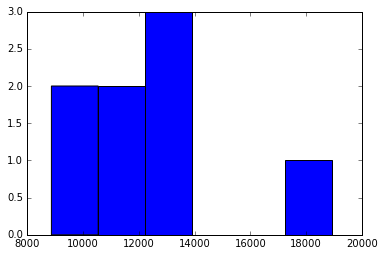

In [60]:
plt.hist( mouton_1982[ 'UnitPriceUSD'], 6 )
plt.show()

### Let's Try Your Own!

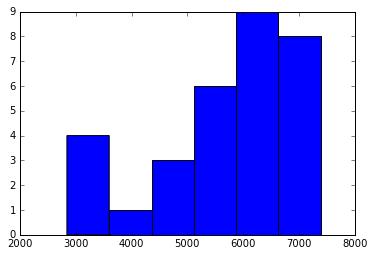

In [61]:
Vintage = "1999"
Producer = "Domaine de la Romanee Conti"
Wine = "La Tache"
producer_only = bottle_df[ bottle_df["ProducerAndDesignation"].str.contains(Producer) ]
producer_wine = producer_only[ producer_only["Wine"].str.contains(Wine) ]

producer_wine_vintage = producer_wine[ producer_wine['Vintage'] == Vintage ]

plt.hist( producer_wine_vintage['UnitPriceUSD'], 6 )
plt.show()

In [62]:
producer_wine_vintage.head()

,index,Auction.Date,Auction.ID,Auction.Name,BottleQuantity,BottleSummary,Conditions,Designation,LotNo,Producer,ProducerAndDesignation,Size,SoldAmount,Vintage,Wine,SoldAmountUSD,UnitPriceUSD
545,759,None,1185,"183 Apr 7, 2018 (NY)",6,6 bottles,,None,611,Domaine de la Romanee Conti,Domaine de la Romanee Conti,bottle,32240.0,1999,La Tache,32240.00,5373.333333
1094,521,None,1187,"183A Apr 21, 2018 (HK)",6,6 bottles,1x6 bottle banded owc,None,446,Domaine de la Romanee Conti,Domaine de la Romanee Conti,bottle,272800.0,1999,La Tache,34836.56,5806.093333
1149,578,None,1187,"183A Apr 21, 2018 (HK)",12,12 bottles,1nl 1wol,None,501,Domaine de la Romanee Conti,Domaine de la Romanee Conti,bottle,272800.0,1999,La Tache,34836.56,2903.046667
1150,579,None,1187,"183A Apr 21, 2018 (HK)",6,6 bottles,1 different importer 1nl 3vlbsl 3wol,None,502,Domaine de la Romanee Conti,Domaine de la Romanee Conti,bottle,136400.0,1999,La Tache,17418.28,2903.046667
1624,587,None,1188,"184 May 16, 2018 (NY)",1,1 bottle,lscl lstl lwrl,None,289,Domaine de la Romanee Conti,Domaine de la Romanee Conti,bottle,5952.0,1999,La Tache,5952.00,5952.000000


## PnL Opportunity

In [162]:
bottle_profit = bottle_grouped[ bottle_grouped["max"] / 1.25 > bottle_grouped["min"] ]
bottle_profit = bottle_profit.reset_index()
bottle_profit['diff'] = bottle_profit['max'] / 1.25 - bottle_profit['min']
bottle_profit = bottle_profit[ bottle_profit["count"] > 10 ]
bottle_profit = bottle_profit.sort_values('diff', ascending = False)
print(bottle_profit.shape)
bottle_profit.head()

(73, 9)


,index,Vintage,Wine,ProducerAndDesignation,min,mean,max,count,diff
4,2314,1999,Romanee Conti,Domaine de la Romanee Conti,10028.706667,18481.627333,23224.373333,24,8550.792
2,2274,1999,La Tache,Domaine de la Romanee Conti,2841.666667,5658.579462,7389.573333,31,3069.992
39,2195,1999,Chambertin,A. Rousseau,899.000000,2914.087885,4960.000000,13,3069.000
42,1321,1990,Chambertin,A. Rousseau,3224.000000,4757.275897,7750.000000,13,2976.000
66,2850,2002,Romanee Conti,Domaine de la Romanee Conti,12616.760000,15934.525697,19001.760000,11,2584.648


## NEXT HEADER

## ToDos

In [18]:
#TODO list!
#check auction scraping - all web and in person
#can we scrape more dates? the archives go back longer
#PnL 
#Trend over time
#Expected inventory, distributions of profit? strategies? always buy < max?)
#Lot sizes makes difference?
#Ullage level?
#Label condition?
#mixed lots built from single bottles?